In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

import caffe



In [6]:
def vis_square(data):
    """
    Copied from Caffe tutorial 00-classification
    Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

# Inject data from memory to Caffe

In [47]:
from caffe import layers as L, params as P
def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
#    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=5, weight_filler=dict(type='xavier'))
#    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool1, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=100, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('data/train_lmdb', 16)))
    
with open('lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('data/test_lmdb', 32)))

In [48]:
solver_path = 'solver.prototxt'
solver_proto = """\
# The train/test net protocol buffer definition
train_net: "lenet_auto_train.prototxt"
test_net: "lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "lenet"
"""

open(solver_path,'w').write(solver_proto)


In [49]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [50]:
solver = None
solver = caffe.SGDSolver(solver_path)

Assingning memory buffers to the input layers

In [51]:
print "Blob shapes"
print "-----------"
print "\n".join(["%8s: %s" % (k, str(v.data.shape)) for k, v in solver.net.blobs.items()])

print ""
print "Parameter shapes"
print "----------------"
print "\n".join(["%8s: %s" % (k, str(v[0].data.shape)) for k, v in solver.net.params.items()])

Blob shapes
-----------
    data: (16, 3, 256, 256)
   label: (16,)
   conv1: (16, 20, 252, 252)
   pool1: (16, 20, 126, 126)
     fc1: (16, 500)
   score: (16, 100)
    loss: ()

Parameter shapes
----------------
   conv1: (20, 3, 5, 5)
     fc1: (500, 317520)
   score: (100, 500)


In [55]:
solver.step(10)

In [2]:
data = solver.net.blobs['data'].data
vis_square(data.transpose(0, 2, 3, 1)[:,:,:,::-1])

NameError: name 'solver' is not defined

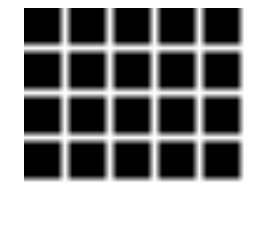

In [57]:
par_conv1 = solver.net.params['conv1'][0].data
vis_square(par_conv1.transpose(0, 2, 3, 1)[:,:,:,::-1])